# Conv1D + LSTM + DNN on Time Series Sunspots Dataset from Kaggle:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%205.ipynb


Kaggle Sunspots: https://www.kaggle.com/robervalt/sunspots


LSTM Andrew Ng:  https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay

- We add a Convolution 1D layer at the beginning.
- RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
- However, we won't use a Lambda layer to expand the dims but we'll do it in the dataset preparation function. Since our dataset is 2D [batch_size, window_size], we'll have to expand using tf.exapnd_dims.
- RNN only outputs the last sequence (last time step) by default, if we want to get the output for all the sequences (all time steps) to feed it into a lower RNN, we need to use return_sequences=True.
- RNN use 'tanh' as activation function by default.
- Simple RNN use the output as the state vector recurred (fed back) to the next time step.
- LSTM carry a cell state from step 0 to the end time step in order that initial information has bigger impact on latter time steps than on the simple RNN.
- Bidirectional then carries info from 0 to end and then from end to 0.

TF Keras Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

TF Keras LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

TF Keras DNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense


mini-batch gradient descent Andrew Ng: https://www.youtube.com/watch?v=4qJaSmvhxi8

Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

2.2.0-rc2


In [0]:
uploaded=files.upload()

Saving sunspots.zip to sunspots.zip


In [0]:
import os 

os.chdir('/content/')
print(os.getcwd())
print(os.listdir(os.getcwd()))
os.rename("/content/sunspots.zip", "/tmp/sunspots.zip")  # move the file from one folder to another
os.chdir('/tmp/')
print(os.getcwd())
print(os.listdir(os.getcwd()))


import zipfile

local_zip = '/tmp/sunspots.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()
print(os.getcwd())
print(os.listdir(os.getcwd()))

os.rename("/tmp/Sunspots.csv", "/tmp/sunspots.csv")  # move the file from one folder to another
print(os.getcwd())
print(os.listdir(os.getcwd()))

/content
['.config', 'sunspots.zip', 'sample_data']
/tmp
['sunspots.zip']
/tmp
['Sunspots.csv', 'sunspots.zip']
/tmp
['sunspots.csv', 'sunspots.zip']


In [0]:
# # Alternative from Laurence database:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

In [0]:
# reading the dataset with pandas: 
df = pd.read_csv('/tmp/sunspots.csv', sep=',', engine='python')

# df.columns = ['Time-step Number', 'Date', 'Monthly Mean Total Sunspot Number']
df.columns.values[0] = 'Time-step Number'  # assign a name to column index 0!

print(df.head())

   Time-step Number        Date  Monthly Mean Total Sunspot Number
0                 0  1749-01-31                               96.7
1                 1  1749-02-28                              104.3
2                 2  1749-03-31                              116.7
3                 3  1749-04-30                               92.8
4                 4  1749-05-31                              141.7


In [0]:
# Helper function for plotting charts:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


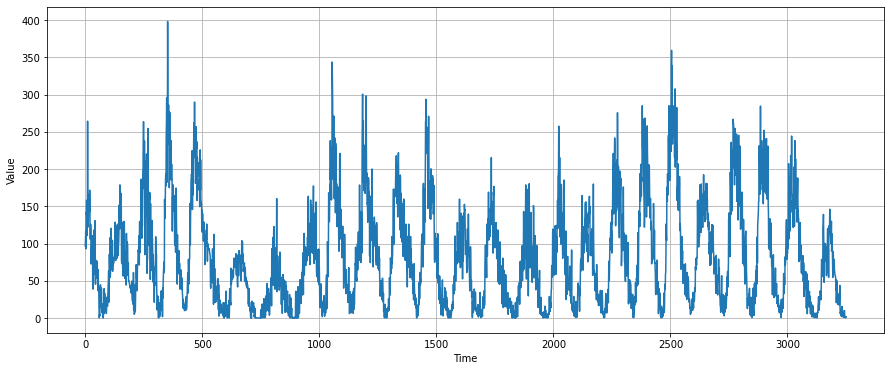

In [0]:
# Defining the time series: 
time_steps = df['Time-step Number'].values  # already converted to np array
sunspots = df['Monthly Mean Total Sunspot Number'].values  # already converted to np array
time = time_steps
series = sunspots

# # Alternative from Coursera:
# with open('/tmp/sunspots.csv') as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     sunspots.append(float(row[2]))
#     time_step.append(int(row[0]))

# series = np.array(sunspots)
# time = np.array(time_step)


print(type(time))
print(type(series))

plt.figure(figsize=(15,6))
plot_series(time, sunspots)


In [0]:
# Spliting the data into Training and Validation sets:

time_split = 3000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 60  # window_size is the number of features!
batch_size = 100 # 128
shuffle_buffer_size = 1000

# Conv1D+LSTM+DNN Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  series = tf.expand_dims(series, axis=-1)                                            # With Conv1D we expand the dimension of the dataset here instead of with a Lambda layer!!!
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  # dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))                     # !!! careful !!! if we returen sequences from the LSTM labels need to be from 1: on not just the last one!!!
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,     # 32 filters of chuncks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 10)          650       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 42,325
Trainable params: 42,325
Non-trainable params: 0
____________________________________________________

In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 3s 116ms/step - loss: 90.4940 - mae: 90.8300 - mse: 13071.6113 - accuracy: 0.0218
Epoch 2/100
30/30 [==============================] - 3s 116ms/step - loss: 83.3976 - mae: 83.8179 - mse: 11756.0820 - accuracy: 0.0196
Epoch 3/100
30/30 [==============================] - 3s 114ms/step - loss: 74.3505 - mae: 74.8189 - mse: 10023.1172 - accuracy: 0.0167
Epoch 4/100
30/30 [==============================] - 4s 118ms/step - loss: 64.4243 - mae: 64.9140 - mse: 8123.6167 - accuracy: 0.0146
Epoch 5/100
30/30 [==============================] - 3s 113ms/step - loss: 57.3602 - mae: 57.7588 - mse: 6771.0435 - accuracy: 0.0128
Epoch 6/100
30/30 [==============================] - 3s 113ms/step - loss: 53.0252 - mae: 53.3662 - mse: 5918.8701 - accuracy: 0.0116
Epoch 7/100
30/30 [==============================] - 3s 113ms/step - loss: 50.0627 - mae: 50.5053 - mse: 5337.5688 - accuracy: 0.0109
Epoch 8/100
30/30 [==============================] - 3s 115

In [0]:
# Function to performn the forecasting for us after training:

def model_forecast(model, series, window_size) :
  ds = tf.data.Dataset.from_tensor_slices(series)                    # create a tf dataset
  ds = ds. window(size=window_size, shift = 1, drop_remainder=True)  # no need to add the window_size + 1 here as for predicting we don't add the label!
  ds = ds.flat_map(lambda window: window.batch(window_size) )        # we flatten the data into chunks of window_size
  ds = ds.batch(32).prefetch(1)                     # the split dataset is batched in batches of the specified size.
  forecast = model.predict(ds)

  return forecast


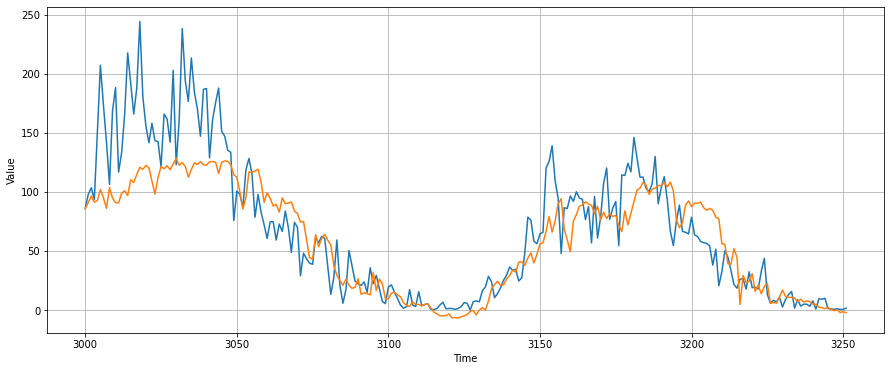

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
# Getting the predictions of the validation set only
forecast = model_forecast(model, series[..., np.newaxis], window_size) 
forecast = forecast[time_split-window_size:-1]   # !!! Careful here!!! -> the predictions index are shifted by window_size
# results = np.array(forecast)[:,0,0]     # use this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
results = np.array(forecast)[:,-1,0]      # use this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.     

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


# # Alternative:
# # Calculating predictions by picking up slices of window_size each time:
# forecast = model_forecast(model, series[..., np.newaxis], window_size)   # remember that we need to expand the dim of the dataset. Here we use np.newaxis

# print(len(forecast))
# print(forecast[:2])

# # Getting the predictions of the validation set only
# forecast = forecast[time_split-window_size:-1, -1, 0]  # !!! Careful here!!! -> the predictions index are shifted by window_size
#                                                        # use this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
# # forecast = forecast[time_split-window_size:-1, 0, 0]   # use this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.                                                   
# results = forecast # np.array(forecast)[:,0,0]  

# plt.figure(figsize=(15,6))

# plot_series(time_val, x_val)
# plot_series(time_val, results)
# plt.show()


In [0]:
print(results.shape)
print(results[:10])

(252,)
[ 85.773155  90.91865   96.4739    91.32519   92.75305  101.95724
  95.06807   86.0286   103.53279   94.699684]


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

1001.4208
21.138319


# CNN1D+LSTM+DNN with learning rate sweep:

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,     # 32 filters of chuncks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 10)          650       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 42,325
Trainable params: 42,325
Non-trainable params: 0
____________________________________________________

In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
30/30 [==============================] - 3s 116ms/step - loss: 92.3815 - mae: 92.6635 - mse: 13416.9395 - accuracy: 0.0221 - lr: 1.0000e-08
Epoch 2/100
30/30 [==============================] - 3s 113ms/step - loss: 91.6173 - mae: 91.9723 - mse: 13290.7373 - accuracy: 0.0219 - lr: 1.1220e-08
Epoch 3/100
30/30 [==============================] - 3s 116ms/step - loss: 90.7541 - mae: 91.1036 - mse: 13131.5576 - accuracy: 0.0217 - lr: 1.2589e-08
Epoch 4/100
30/30 [==============================] - 3s 115ms/step - loss: 89.6935 - mae: 90.0957 - mse: 12945.2744 - accuracy: 0.0215 - lr: 1.4125e-08
Epoch 5/100
30/30 [==============================] - 4s 117ms/step - loss: 88.6068 - mae: 88.9714 - mse: 12737.0752 - accuracy: 0.0212 - lr: 1.5849e-08
Epoch 6/100
30/30 [==============================] - 3s 115ms/step - loss: 87.3925 - mae: 87.7043 - mse: 12499.8164 - accuracy: 0.0208 - lr: 1.7783e-08
Epoch 7/100
30/30 [==============================] - 4s 117ms/step - loss: 85.7601 - mae

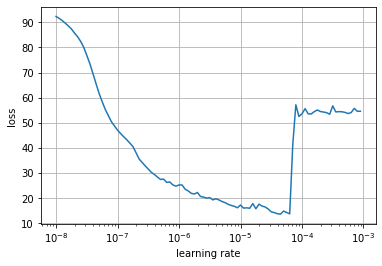

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
# plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the CNN1D+LSTM+DNN with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,     # 60 filters of chunks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.LSTM(60, return_sequences=True))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.LSTM(60, return_sequences=True))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(30, activation='relu'))   # The DNN looked from Less2 exercise, so we won't touch it.
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
30/30 [==============================] - 3s 114ms/step - loss: 45.3519 - mae: 46.0549 - mse: 4254.0171 - accuracy: 0.0049
Epoch 2/400
30/30 [==============================] - 3s 112ms/step - loss: 28.0771 - mae: 28.5808 - mse: 1808.7747 - accuracy: 0.0056
Epoch 3/400
30/30 [==============================] - 3s 114ms/step - loss: 23.3400 - mae: 23.8494 - mse: 1244.4075 - accuracy: 0.0042
Epoch 4/400
30/30 [==============================] - 3s 112ms/step - loss: 21.0972 - mae: 21.5673 - mse: 1007.5882 - accuracy: 0.0037
Epoch 5/400
30/30 [==============================] - 3s 113ms/step - loss: 20.5574 - mae: 21.0599 - mse: 947.7526 - accuracy: 0.0040
Epoch 6/400
30/30 [==============================] - 3s 110ms/step - loss: 19.9663 - mae: 20.4600 - mse: 893.9401 - accuracy: 0.0043
Epoch 7/400
30/30 [==============================] - 3s 111ms/step - loss: 19.4475 - mae: 19.9614 - mse: 846.8642 - accuracy: 0.0039
Epoch 8/400
30/30 [==============================] - 3s 111ms/ste

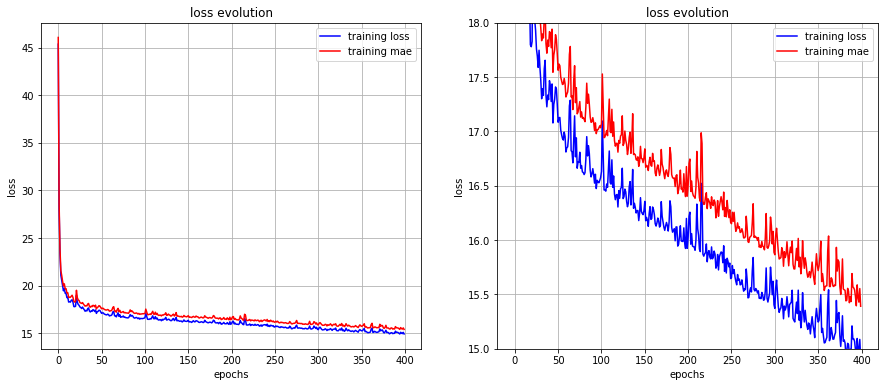

In [0]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((15,18))
plt.title('loss evolution')
plt.legend()

plt.show()

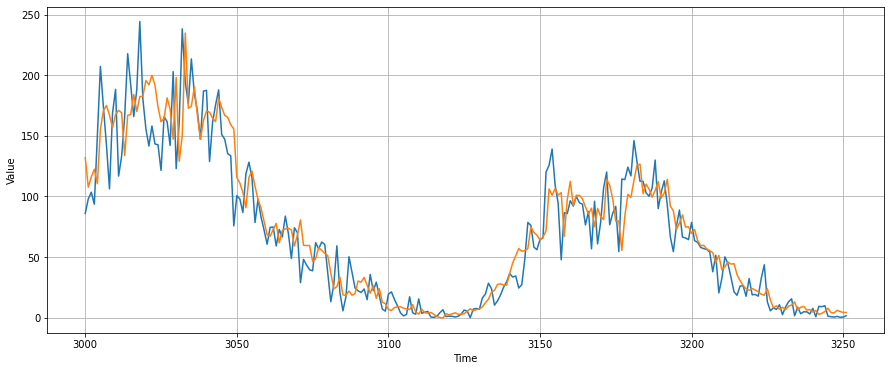

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
# Getting the predictions of the validation set only
forecast = model_forecast(model, series[..., np.newaxis], window_size) 
forecast = forecast[time_split-window_size:-1]   # !!! Careful here!!! -> the predictions index are shifted by window_size
# results = np.array(forecast)[:,0,0]     # use this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
results = np.array(forecast)[:,-1,0]      # use this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.     

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


# # Alternative:
# # Calculating predictions by picking up slices of window_size each time:
# forecast = model_forecast(model, series[..., np.newaxis], window_size)   # remember that we need to expand the dim of the dataset. Here we use np.newaxis

# print(len(forecast))
# print(forecast[:2])

# # Getting the predictions of the validation set only
# forecast = forecast[time_split-window_size:-1, -1, 0]  # !!! Careful here!!! -> the predictions index are shifted by window_size
#                                                        # use this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
# # forecast = forecast[time_split-window_size:-1, 0, 0]   # use this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.                                                   
# results = forecast # np.array(forecast)[:,0,0]  

# plt.figure(figsize=(15,6))

# plot_series(time_val, x_val)
# plot_series(time_val, results)
# plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

459.74323
14.6979


In [0]:
# Forecasts for all validation set:

print(results)

[ 1.31921631e+02  1.07645584e+02  1.16197052e+02  1.22423080e+02
  1.10467842e+02  1.55351700e+02  1.71140289e+02  1.74988724e+02
  1.67040619e+02  1.56805450e+02  1.67556900e+02  1.71017334e+02
  1.69037537e+02  1.33704880e+02  1.66886993e+02  1.67665390e+02
  1.84076691e+02  1.70004181e+02  1.82410156e+02  1.82603333e+02
  1.95659225e+02  1.92091873e+02  1.99922211e+02  1.91846130e+02
  1.73891541e+02  1.61582718e+02  1.64415817e+02  1.81326553e+02
  1.72038361e+02  1.47210068e+02  1.98165176e+02  1.28994980e+02
  1.49873184e+02  2.34795853e+02  1.72742691e+02  1.74230423e+02
  1.90411209e+02  1.66629837e+02  1.47052185e+02  1.62696014e+02
  1.70441696e+02  1.69461670e+02  1.64618500e+02  1.61704956e+02
  1.81030029e+02  1.73547607e+02  1.66808624e+02  1.65269821e+02
  1.59156326e+02  1.55654617e+02  1.15628708e+02  1.11048256e+02
  1.03353561e+02  9.06807785e+01  1.15835785e+02  1.20871696e+02
  1.08335091e+02  9.74272156e+01  9.03932800e+01  7.92111740e+01
  6.83355484e+01  6.72026